<h1><h1>Pre-trained-Models with PyTorch </h1>


I will use pre-trained models to classify between the negative and positive samples;  provided with the dataset object. The particular pre-trained model will be resnet18; 
<ul>
<li>change the output layer</li>
<li> train the model</li>
<li>  identify  several  misclassified samples</li>
 </ul>
You will take several screenshots of your work and share your notebook.


<h2>Table of Contents</h2>


<div class="alert alert-block alert-info" style="margin-top: 20px">


<ul>
    <li><a href="#download_data"> Download Data</a></li>
    <li><a href="#auxiliary"> Imports and Auxiliary Functions </a></li>
    <li><a href="#data_class"> Dataset Class</a></li>
 


<h2 id="download_data">Download Data</h2>


Download the dataset and unzip the files in your data directory, unlike the other labs, all the data will be deleted after you close  the lab, this may take some time:


In [ ]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip

In [2]:
!unzip -q Positive_tensors.zip

In [3]:
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
!unzip -q Negative_tensors.zip

--2025-01-17 18:31:01--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111408108 (2.0G) [application/zip]
Saving to: ‘Negative_tensors.zip’

Negative_tensors.zi 100%[===================>]   1.97G  33.4MB/s    in 62s     

2025-01-17 18:32:04 (32.4 MB/s) - ‘Negative_tensors.zip’ saved [2111408108/2111408108]



We will install torchvision:


In [4]:
!pip install torchvision

<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


The following are the libraries we are going to use for this lab. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.


In [5]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [6]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->


<h2 id="data_class">Dataset Class</h2>


 This dataset class is essentially the same dataset you build in the previous section, but to speed things up, we are going to use tensors instead of jpeg images. Therefor for each iteration, you will skip the reshape step, conversion step to tensors and normalization step.


In [14]:
# Create your own dataset object
class Dataset(Dataset):

    # Constructor
    def __init__(self, transform=None, train=True):
        # Get the current working directory
        directory = os.getcwd()
        positive = "Positive_tensors"
        negative = "Negative_tensors"

        positive_file_path = os.path.join(directory, positive)
        negative_file_path = os.path.join(directory, negative)

        positive_files = [os.path.join(positive_file_path, file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files = [os.path.join(negative_file_path, file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]

        number_of_samples = len(positive_files) + len(negative_files)
        self.all_files = [None] * number_of_samples
        self.all_files[::2] = positive_files
        self.all_files[1::2] = negative_files

        # The transform is going to be used on image
        self.transform = transform

        # torch.LongTensor
        self.Y = torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2] = 1
        self.Y[1::2] = 0

        if train:
            self.all_files = self.all_files[0:30000]
            self.Y = self.Y[0:30000]
            self.len = len(self.all_files)
        else:
            self.all_files = self.all_files[30000:]
            self.Y = self.Y[30000:]
            self.len = len(self.all_files)

    # Get the length
    def __len__(self):
        return self.len

    # Getter
    def __getitem__(self, idx):
        image = torch.load(self.all_files[idx])
        y = self.Y[idx]

        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

We create two dataset objects, one for the training data and one for the validation data.


In [15]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


<b>Prepare a pre-trained resnet18 model :</b>


<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:


In [16]:
# Step 1: Load the pre-trained model resnet18
model = models.resnet18(pretrained=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 122MB/s]


<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.


In [17]:
# Step 2: Set the parameter cannot be trained for the pre-trained model

for param in model.parameters():
    param.requires_grad = False


<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs.


<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.


In [18]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

Print out the model in order to show whether you get the correct answer.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>


In [19]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In this question you will train your, model:


<b>Step 1</b>: Create a cross entropy criterion function


In [20]:
# Step 1: Create the loss function
criterion = nn.CrossEntropyLoss()


<b>Step 2</b>: Create a training loader and validation loader object, the batch size should have 100 samples each.


In [21]:
train_loader = DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=100)

<b>Step 3</b>: Use the following optimizer to minimize the loss


In [22]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

<!--Empty Space for separating topics-->


**code to calculate  the accuracy on the validation data for one epoch; this should take about 45 minutes. Make sure you calculate the accuracy on the validation data.**

In [24]:
n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()
#n_epochs

Loss=0
start_time = time.time()
for epoch in range(n_epochs):
    for x, y in train_loader:

        model.train()
        #clear gradient
        optimizer.zero_grad()
        #make a prediction
        z = model(x)
        # calculate loss
        loss = criterion(z, y)
        # calculate gradients of parameters
        loss.backward()
        # update parameters
        optimizer.step()

        loss_list.append(loss.data)
    correct=0
    for x_test, y_test in validation_loader:
        # set model to eval
        model.eval()
        #make a prediction
        z = model(x_test)
        #find max
        _, yhat = torch.max(z.data, 1)

        #Calculate misclassified  samples in mini-batch
        #hint +=(yhat==y_test).sum().item()
        correct += (yhat == y_test).sum().item()

    accuracy=correct/N_test

<ipython-input-14-2b23f72feeab>:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(self.all_files[idx])


<b>Print out the Accuracy and plot the loss stored in the list <code>loss_list</code> for every iteration and take a screen shot.</b>


In [25]:
accuracy

0.9945

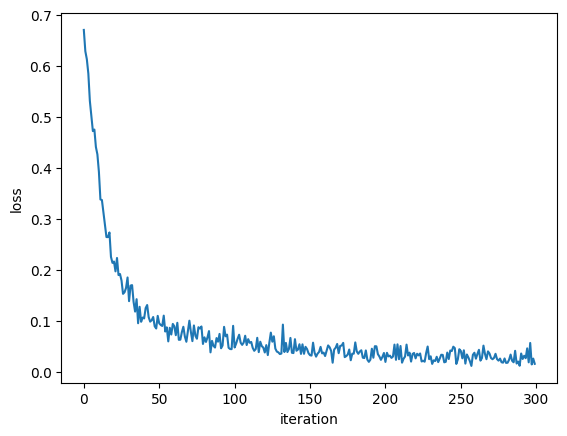

In [26]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


<b>Identify the first four misclassified samples using the validation data:</b>


<ipython-input-14-2b23f72feeab>:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(self.all_files[idx])


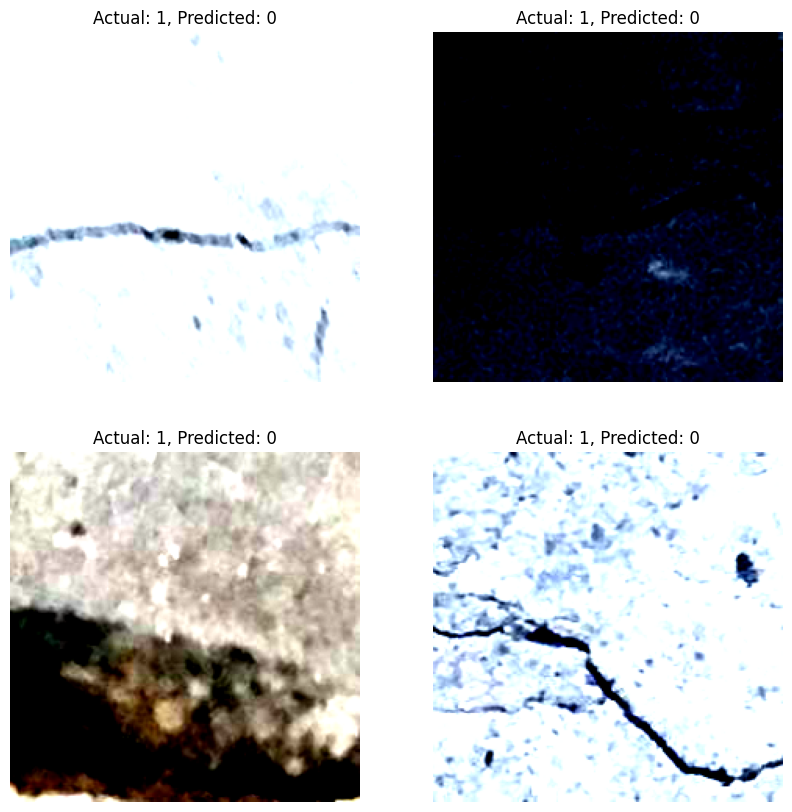

In [27]:
import matplotlib.pyplot as plt

# Assuming you already have the validation_loader, model, and necessary imports

count = 0
misclassified_images = []
actual_labels = []
predicted_labels = []

for x_test, y_test in validation_loader:
    model.eval()
    z = model(x_test)
    _, yhat = torch.max(z.data, 1)

    for i in range(len(y_test)):
        if yhat[i] != y_test[i]:
            misclassified_images.append(x_test[i])
            actual_labels.append(y_test[i].item())
            predicted_labels.append(yhat[i].item())
            count += 1
            if count == 4:  # Stop after finding 4 misclassified samples
                break
    if count == 4:
        break

# Display the misclassified images with actual and predicted labels
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.ravel()

for i in range(4):
    axs[i].imshow(misclassified_images[i].permute(1, 2, 0))  # Permute to (H, W, C) for display
    axs[i].set_title(f"Actual: {actual_labels[i]}, Predicted: {predicted_labels[i]}")
    axs[i].axis('off')

plt.show()